Machine Learning Pipeline for House Prediction

Problem Statement
Our company Nyumabi GmbH is looking to investing in rental properties and they would like to buy houses in India. I have been given a data set and told to create a pipeline that the company can use to try and estimate the cost of houses in India before decideing to purchase.

In this Pipeline I will import the data, clean it, preprocess it using the relevant packages and processes and then proceed to build the pipeline. My company hopes to use this model for estimation so that they can know where to focus on buying properties.

The following machine learning pipeline is for determining rent prices in India.
The data set was gotten from Kaggle using this link - https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data/data

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 8)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [5]:
df = pd.read_csv("~/Desktop/Codes/house_price_prediction/Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df.shape

(13320, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [8]:
df1 = df.drop(['area_type', 'availability', 'society', 'balcony'], axis='columns')
df1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [9]:
df1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df1 = df1.dropna()

df1.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
#Exploring the 'size' column and making the necessary updates.
#Getting the first digit in the 'size' column
df1['bhk'] = df1['size'].str.split(' ').str[0]
df1['bhk'] = df1['bhk'].astype(int)
df1.drop(['size'], axis='columns', inplace=True)
df1.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [12]:
#Funtion to convert the 'total_sqrt' column to numeric, and if there are any ranges, we will get the mean of the range otherwise any other value that row will be deleted.
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None
    
print('Function created')

Function created


In [13]:
# Ensuring 'total_sqft' column is treated as string before applying the function
df1['total_sqft'] = df1['total_sqft'].astype(str).apply(convert_sqft_to_num)
df1.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [14]:
#Checking for null values in the 'total_sqft' column
df1.isnull().sum()

location       0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [15]:
#Dropping the rows with the null values in the 'total_sqft' column
df1 = df1.dropna()
df1.isnull().sum()

location      0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

In [16]:
df1.shape

(13200, 5)

Feature Engineering

Here I will introduce new columns that will assist me in analyzing the data set. The columns will be deleted further down the line as they will not be useful after assisting me with the data cleaning. This will help me remove outliers in certain rows in the data.

In [17]:
#Creating a new column 'price_per_sqft' by dividing the 'price' column with the 'total_sqft' column
#This will help us detect the outliers in the data.
df1['price_per_sqft'] = df1['price'] * 100000 / df1['total_sqft']
df1.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [18]:
#Exploring the 'location' column
df1['location'].value_counts()

location
Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: count, Length: 1298, dtype: int64

In [19]:
#Grouping the location with less than 15 occurens=ces to 'Other'. This will help in the future for example with encoding.
location_counts = df1['location'].value_counts()
reduce_locations = set(location_counts[location_counts >= 10].index)

#Replacing the locations with less than 15 occurrences with 'Other'd
df1['location'] = df1['location'].apply(lambda x: x if x in reduce_locations else "Other")
df1['location'].value_counts()

location
Other                   2757
Whitefield               532
Sarjapur  Road           392
Electronic City          302
Kanakpura Road           264
                        ... 
Nagappa Reddy Layout      10
BTM 1st Stage             10
Basapura                  10
Kalkere                   10
Nagadevanahalli           10
Name: count, Length: 254, dtype: int64

In [20]:
df1.shape

(13200, 6)

Detecting Outliers.

In [21]:
#Removing the apartments with less than 300 sqft as it is not possible to have a house with less than 300 sqft in that city. That should be a mistake.
df2 = df1[df1.total_sqft/df1.bhk > 300]
df2.shape

(12274, 6)

In [22]:
#Exploring the 'price_per_sqft' column and filtering out the outliers
df2['price_per_sqft'].describe()

count     12274.000000
mean       6211.880230
std        4053.214807
min         267.829813
25%        4200.000000
50%        5263.157895
75%        6825.474875
max      176470.588235
Name: price_per_sqft, dtype: float64

In [23]:
#Removing the outliers in the 'price_per_sqft' column based on the standard deviation and the meaan
def remove_ppl_outliers(df):
    df_out = pd.DataFrame()
    for location, location_df in df.groupby('location'):
        mean = np.mean(location_df['price_per_sqft'])
        std = np.std(location_df['price_per_sqft'])
        reduced_df = location_df[(location_df['price_per_sqft'] > (mean - std)) & (location_df['price_per_sqft'] <= (mean + std))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [24]:
df3 = remove_ppl_outliers(df2)
df3.shape

(9999, 6)

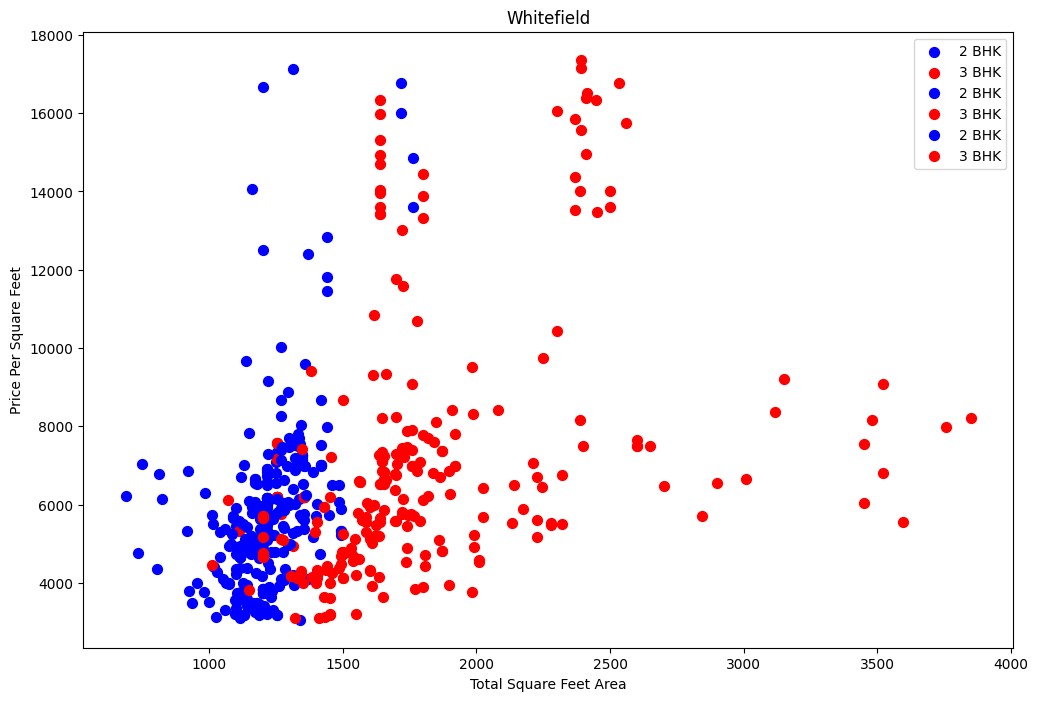

In [25]:
#I want to analyze the 'bhk' column to see it there are any outliers in the data by drawing a scatter plot. I will use the 'price_per_sqft' column to do that for example the bhk that has value of 2 and 3 to see it there are any 3 bhk with a total_sqrt less than 3 bhk. I will use 3 locations to do that.
def plot_scatter_chart(df, location):
    bhk2 = df[(df['location'] == location) & (df['bhk'] == 2)]
    bhk3 = df[(df['location'] == location) & (df['bhk'] == 3)]
    plt.scatter(bhk2['total_sqft'], bhk2['price_per_sqft'], color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3['total_sqft'], bhk3['price_per_sqft'], color='red', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(location)
    plt.legend()
plot_scatter_chart(df3, "Rajaji Nagar")
plot_scatter_chart(df3, "Hebbal")
plot_scatter_chart(df3, "Whitefield")

In [26]:
#We can see that there are some 3 BHK apartments with a total_sqrt less than 2 BHK apartments. This is not possible. So I will remove these outliers.
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqft']),
                'std': np.std(bhk_df['price_per_sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft'] < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')
df4 = remove_bhk_outliers(df3) 

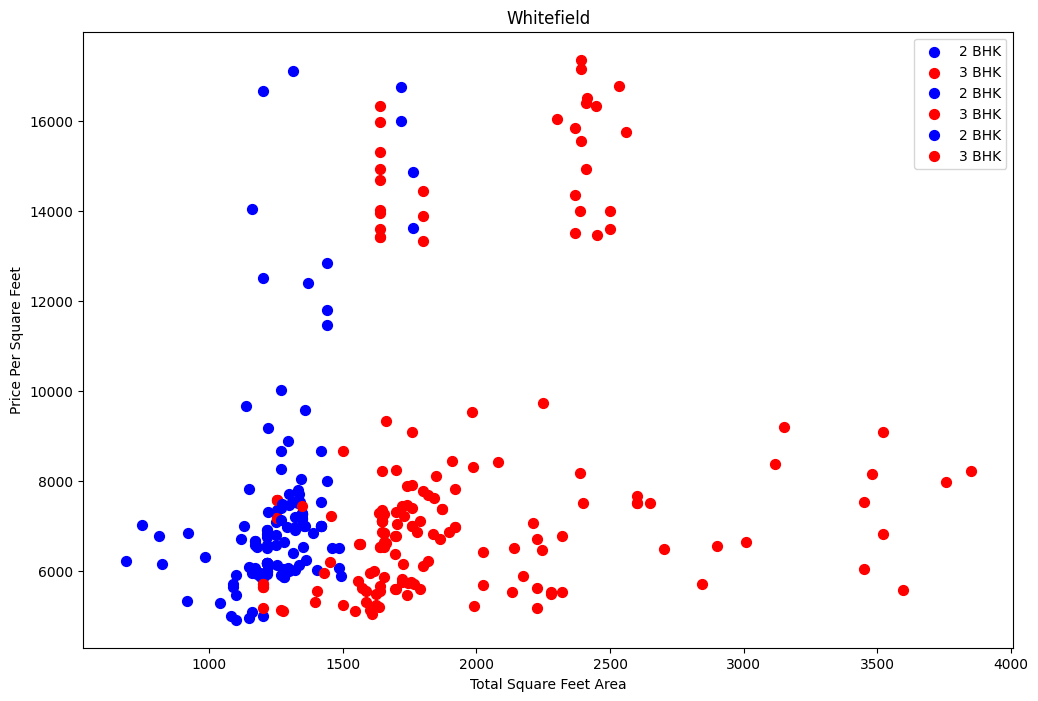

In [27]:
#plotting thw scatter plot again to see if there are any outliers and if they ahve reduced.
plot_scatter_chart(df4, "Rajaji Nagar")
plot_scatter_chart(df4, "Hebbal")
plot_scatter_chart(df4, "Whitefield")

In [28]:
df4.shape

(7217, 6)

Based on the above output we can see that the data has been reduced to only remain with the relevant data. I will now proceed to delete the unnecessary columns that will not be needed.

In [29]:
#Explorinng the 'bath' column to see if there are any outliers. 
# I will remove the bath that are 2 more than the bhk. Foe example if the bhk is 2, then the bath should be 4. More than that is not correct, less than that is ok.
#I will use the 'location' column to do that.
#Function to remove the outliers in the 'bath' column. bath should be less than or equal to bhk + 2.
def remove_bath_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        for bhk, bhk_df in location_df.groupby('bhk'):
            if bhk_df['bath'].values[0] > bhk + 2:
                exclude_indices = np.append(exclude_indices, bhk_df.index.values)
    return df.drop(exclude_indices, axis='index')
df5 = remove_bath_outliers(df4)
df5.shape

(7215, 6)

In [30]:
#Droppin the unnecessary columns
df5 = df5.drop(['price_per_sqft'], axis='columns')
df5.head()

,location,total_sqft,bath,price,bhk
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2


Model Building and Training

In [31]:
#Encoding the 'location' column using one hot encoding. The encoding will be represented as 1 and 0. We will have the introduction of a lot of columns in the dataset.
dummies = pd.get_dummies(df5['location']).astype(int)
df5 = pd.concat([df5, dummies.drop('Other', axis='columns')], axis='columns')
df5.head()
df5 = df5.drop(['location'], axis='columns')
df5.head()

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,65.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,43.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Getting the dependent and independent variables
X = df5.drop(['price'], axis='columns')
X.head()

,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y = df5['price']
y.head()

1    40.0
2    83.0
3    40.0
4    65.0
5    43.0
Name: price, dtype: float64

In [34]:
#Splitting the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
       

((5772, 256), (1443, 256), (5772,), (1443,))

I will begin with Logistic Regression just to get a grasp of how the model can perform then I will introduce other models as comparisons so that I can determine the best model to use.

In [35]:
#Training the model using Linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
#Getting the score of the model
model.score(X_test, y_test)

0.848078212698447

Getting the value above shows that linear regression is a decent model for the analysis. But I will try other models to determine the best model to use for the pipeline. We need the best model for the pipeline.

In [37]:
from sklearn.model_selection import GridSearchCV

def get_best_model(X, y, X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": (LinearRegression(), {}),
        "Ridge Regression": (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
        "Lasso Regression": (Lasso(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
        "ElasticNet Regression": (ElasticNet(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
        "Random Forest": (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    }

    # List to store model results
    results = []  
    best_model = None
    best_score = float('-inf')

    for model_name, (model, params) in models.items():
        try:
            if params:  
                grid_search = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model_score = grid_search.best_score_
                model_params = grid_search.best_params_
                model_instance = grid_search.best_estimator_
            else:  
                model.fit(X_train, y_train)
                model_score = model.score(X_test, y_test)
                model_params = "Default parameters"
                model_instance = model

            if model_score > best_score:
                best_model = model_instance
                best_score = model_score

            results.append({"Model": model_name, "Best Score": model_score, "Best Params": model_params})
            
        except Exception as e:
            print(f"Error with model {model_name}: {e}")
            continue
        
    return pd.DataFrame(results), best_model, best_score

results_df, model_name, model_score = get_best_model(X, y, X_train, X_test, y_train, y_test)
print(results_df)

                   Model  Best Score                             Best Params
0      Linear Regression    0.848078                      Default parameters
1       Ridge Regression    0.851557                          {'alpha': 0.1}
2       Lasso Regression    0.848073                         {'alpha': 0.01}
3  ElasticNet Regression    0.775501                         {'alpha': 0.01}
4          Random Forest    0.807475  {'max_depth': 20, 'n_estimators': 100}


From the table above with the 5 models I tried, you can see that Ridge Regression would be the best and suitable model to use for this model building as it has the best score.

In [38]:
def predict_rent_from_input(X_train, y_train, location, total_sqft, bhk, bath, alpha=0.1):
    # Preparing the input data for prediction using the model
    input_data = pd.DataFrame({
        'location': [location],
        'total_sqft': [total_sqft],
        'bath': [bath],
        'bhk': [bhk]
    })

    # Ensuring the input data is one-hot encoded like X_train so that we don't get errors
    input_data_encoded = pd.get_dummies(input_data)
    X_train_encoded = pd.get_dummies(X_train)

    # Aligning the columns of input_data_encoded with X_train_encoded
    input_data_encoded = input_data_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    # Training the Ridge Regression with the best alpha to prvent overfitting and ensure the model is trained well.
    model = Ridge(alpha=alpha)
    model.fit(X_train_encoded, y_train)

    # Predict rent for the given input data
    predicted_rent = model.predict(input_data_encoded)

    return predicted_rent[0]

In [39]:
#Using the function now to predict the price.
predicted_rent = predict_rent_from_input(X_train, y_train, "1st Block Jayanagar", 1200, 2, 2)
print(f"Predicted Rent: {predicted_rent}")

Predicted Rent: 93.87840160012593


I tried using the values that are in the data to try and see if it will predict the same price of the house but it did not. This is to be expected as the goal of this model is to generalize unseen data, not to memorize the training data. Even though this model is trained on my data set, it won't predict the rent of the house as written in the data set as shown in the code below. 
It determined that the rent of the house in 'Chikka Tirupathi' with 2600 total_sqft would cost 207 while in the data sst it says it will cost 140.

In [40]:
predicted_rent = predict_rent_from_input(X_train, y_train, "Chikka Tirupathi", 2600, 5, 4)
print(f"Predicted Rent: {predicted_rent}")

Predicted Rent: 207.7309373182776


In [41]:
predicted_rent = predict_rent_from_input(X_train, y_train, "1st Phase JP Nagar", 1000, 2, 2)
print(f"Predicted Rent: {predicted_rent}")

Predicted Rent: 78.04222348079473


Overally the model provides a high score of approximately 85%. The pipeline is flexible and can be scaled to handle more data and additional features when needed.
The most important features in my model were the location, total_sqrt, bath and bhk. These were very important as they are the once that people usuaaly are very strict about when searching for a house to rent

Limitations.
1. The model's performance is constrained by the quality and completeness of the data, e.g. inaccurate features affected the predictions.
2. The model assumes that features like "total_sqft" and "bath" directly influence the rent. In reality, other factors like local economic trends also plays a significant role that the model does not capture.

Recommendations.
1. Adding more features like nearness to transportation hubs, schools or shopping centers, could improve the models accuracy.
2. We will have to ensure that the data collected is of high accuracy by making it a bit difficult for the survey fillers to accurately fill the forms that we will use to collect the data.